# Rules-Based System (RBS) For Transaction Fraud Detection

---

## Table of contents

1. [Read/process data](#ReadProcessData)
2. [Rule Generation](#RuleGeneration)
3. [Rule Optimisation](#RuleOptimisation)
4. [Combine rules and remove those which are unnecessary](#CombineRules)
5. [Set up the RBS Pipeline](#SetUpPipeline)
6. [Optimise the RBS Pipeline](#OptimiseThePipeline)
7. [Filter rules for the optimised RBS Pipeline](#FilterRulesForPipeline)
8. [Apply the optimised RBS Pipeline to the test set](#ApplyPipeline)
9. [Convert generated rule conditions to system-ready](#ConvertGenToSys)
10. [Our final rule set and RBS Pipeline](#FinalRuleSet)
11. [There's an easier (and better) way!](#BetterWay)

----

## Import packages

In [1]:
from iguanas.rule_generation import RuleGeneratorDT
from iguanas.rule_optimisation import BayesianOptimiser
from iguanas.metrics.classification import FScore, Precision
from iguanas.metrics.pairwise import JaccardSimilarity
from iguanas.rules import Rules, ConvertProcessedConditionsToGeneral, ReturnMappings
from iguanas.correlation_reduction import AgglomerativeClusteringReducer
from iguanas.rule_selection import SimpleFilter, GreedyFilter, CorrelatedFilter
from iguanas.rbs import RBSPipeline, RBSOptimiser

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders.one_hot import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

sns.set_style('white')

---

## Importing the data <a name="ReadProcessData"></a>

In [2]:
data = pd.read_csv('data/transactions.csv', index_col='eid')

In [3]:
data.shape

(13276, 28)

Then we can split the data into features (*X*) and the target column (*y*):

In [4]:
fraud_column = 'is_fraud'
X = data.drop(
    fraud_column, 
    axis=1
)
y = data[fraud_column]

### Process the data

#### Train/test split

Before applying any data processing steps, we should split the data into training and test sets:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [7]:
X_train.shape, X_test.shape

((9293, 27), (3983, 27))

##### Impute null values

We can now impute the null values. You can use any imputation method you like - here we'll impute using the following methodology:

* Impute numeric values with -1.
* Impute categorical features with the category 'missing'.
* Impute boolean features with 'missing'.

In [8]:
print("Number of null values in X_train:", X_train.isna().sum().sum())

Number of null values in X_train: 4990


In [9]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=object).columns.tolist()
bool_cols = X_train.select_dtypes(include=bool).columns.tolist()

In [10]:
X_train[bool_cols] = X_train[bool_cols].astype(object)
X_test[bool_cols] = X_test[bool_cols].astype(object)

In [11]:
X_train.loc[:, num_cols] = X_train.loc[:, num_cols].fillna(-1)
X_train.loc[:, cat_cols] = X_train.loc[:, cat_cols].fillna('missing')
X_train.loc[:, bool_cols] = X_train.loc[:, bool_cols].fillna('missing')
X_test.loc[:, num_cols] = X_test.loc[:, num_cols].fillna(-1)
X_test.loc[:, cat_cols] = X_test.loc[:, cat_cols].fillna('missing')
X_test.loc[:, bool_cols] = X_test.loc[:, bool_cols].fillna('missing')

In [12]:
print("Number of null values in X_train:", X_train.isna().sum().sum())

Number of null values in X_train: 0


##### One hot encode categorical features

Now we can one hot encode the categorical features:

In [13]:
ohe = OneHotEncoder(use_cat_names=True)

In [14]:
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [15]:
X_train.shape, X_test.shape

((9293, 29), (3983, 29))

---

## Rule generation <a name="RuleGeneration"></a>

In [16]:
p = Precision()
f1 = FScore(beta=1)

### Setup Class Parameters

In [17]:
params = {
    'metric': f1.fit,
    'n_total_conditions': 4,   
    'tree_ensemble': RandomForestClassifier(n_estimators=10, random_state=0),
    'target_feat_corr_types': 'Infer',
    'num_cores': 4,
    'verbose': 1
}

### Instantiate class and run fit method

In [18]:
rg = RuleGeneratorDT(**params)

In [19]:
X_rules_gen_train = rg.fit(
    X=X_train, 
    y=y_train
)

--- Calculating correlation of features with respect to the target ---
--- Returning column datatypes ---
--- Training tree ensemble ---
--- Extracting rules from tree ensemble ---
100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


----

## Rule Optimisation <a name="RuleOptimisation"></a>

In [22]:
with open('data/rule_strings.pkl', 'rb') as f:
    rule_strings = pickle.load(f)

existing_rules = Rules(rule_strings=rule_strings)
existing_rule_lambdas = existing_rules.as_rule_lambdas(as_numpy=False, with_kwargs=True)

### Set up class parameters

In [25]:
params = {
    'rule_lambdas': existing_rule_lambdas,
    'lambda_kwargs': existing_rules.lambda_kwargs,
    'metric': f1.fit,
    'n_iter': 10,
    'num_cores': 4,
    'verbose': 1
}

### Instantiate class and run fit method

In [26]:
ro = BayesianOptimiser(**params)

X_rules_opt_train = ro.fit(
    X=X.loc[X_train.index], 
    y=y_train
)

---

## Combine rules and remove those which are unnecessary <a name="CombineRules"></a>

We now have two sets of rules:

1. Newly generated rules
2. Optimised existing rules

We can combine these rule sets, then apply correlation reduction and filtering methods to remove those which are unneccesary:

In [72]:
# Combine the binary columns of each rule set
X_rules_train = pd.concat([
    X_rules_gen_train, 
    X_rules_opt_train
], axis=1)

In [30]:
X_rules_train.shape

(9293, 48)

### Use Standard filter

In [31]:
fr = SimpleFilter(
    threshold=0.01,
    operator='>=',
    metric=f1.fit,
)

X_rules_train = fr.fit_transform(
    X_rules=X_rules_train, 
    y=y_train
)

In [33]:
X_rules_train.shape

(9293, 44)

### Remove correlated rules

In [34]:
js = JaccardSimilarity()

acfr = AgglomerativeClusteringReducer(
    threshold=0.75,
    strategy='bottom_up', 
    similarity_function=js.fit, 
    metric=f1.fit
)

In [36]:
fcr = CorrelatedFilter(correlation_reduction_class=acfr)

X_rules_train = fcr.fit_transform(
    X_rules=X_rules_train,
    y=y_train
)

In [38]:
X_rules_train.shape

(9293, 32)

### Use Greedy filter

In [39]:
gf = GreedyFilter(
    metric=f1.fit, 
    sorting_metric=p.fit,
    verbose=1
)

X_rules_train = gf.fit_transform(
    X_rules=X_rules_train, 
    y=y_train
)

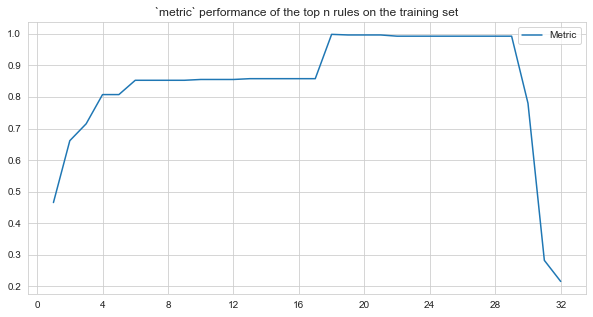

In [41]:
gf.plot_top_n_performance_on_train()

The graph shows that when the rules are sorted by precision, then the F1 score is calculated for the top n combined rules, the combined performance begins to plateau/drop. So the algorithm will only keep those rules that deliver the maximum combined performance (and drop the rest).

In [42]:
X_rules_train.shape

(9293, 18)

----

## Set up the RBS Pipeline <a name="SetUpPipeline"></a>

Now, let's set up our RBS Pipeline using our combined, filtered rule set. In this case, we'll go for a simple approach:

1. If any rules trigger, reject the transaction.
2. If no rules trigger, approve any remaining transactions.

To set up the pipeline using the logic above, we first need to create the `config` parameter. This is just a list which outlines the stages of the pipeline. Each stage should be defined using a tuple of two elements: 

1. The first element should be an integer which corresponds to the decision made at that stage (either `0` or `1`).
2. The second element should be a list that dictates which rules should trigger for that decision to be made.


In [43]:
config = [
    (1, X_rules_train.columns.tolist())
]

Here, the first stage is configured via the tuple in the first element of the list. This says to apply a decision of `1` (i.e. reject) to transactions where the any of the rules have triggered.

We also need to specify the final decision to be made if no rules are triggered - this is set via the `final_decision` parameter. In our case this should be `0`, as we want to approve any remaining transactions:

In [44]:
final_decision = 0

With these parameters configured, we can now instantiate our `RBSPipeline` class:

In [45]:
rbsp = RBSPipeline(
    config=config,
    final_decision=final_decision
)

---

## Optimise the RBS Pipeline <a name="OptimiseThePipeline"></a>

Now that we have our RBS Pipeline set up, we can optimise it using the RBS Optimiser. Here, we just pass the instatiated pipeline class to the `pipeline` parameter:

In [46]:
rbso = RBSOptimiser(
    pipeline=rbsp, 
    metric=f1.fit,
    n_iter=60, 
    verbose=1
)

Then we run the `fit_transform` method to optimise the pipeline using the given dataset, then apply it to the dataset:

In [47]:
pipe_pred_train = rbso.fit_predict(
    X_rules=X_rules_train, 
    y=y_train
)

100%|██████████| 60/60 [00:00<00:00, 67.58trial/s, best loss: -0.9980582524271845] 


In [48]:
rbso.config

[(1,
  ['RGDT_Rule256',
   'RGDT_Rule35',
   'RGDT_Rule313',
   'RGDT_Rule24',
   'RGDT_Rule153',
   'RGDT_Rule_20220803_23',
   'RGDT_Rule137'])]

### Rules Evaluation

In [49]:
print(
    classification_report(
        y_true=y_train, 
        y_pred=pipe_pred_train, 
        digits=4
    )
)

              precision    recall  f1-score   support

         0.0     0.9936    0.9999    0.9967      9036
         1.0     0.9950    0.7743    0.8709       257

    accuracy                         0.9937      9293
   macro avg     0.9943    0.8871    0.9338      9293
weighted avg     0.9937    0.9937    0.9933      9293



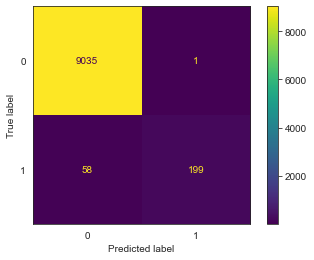

In [51]:
cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=y_train, 
        y_pred=pipe_pred_train
    )
)
cm.plot()

----

## Filter rules for the optimised RBS Pipeline <a name="FilterRulesForPipeline"></a>

In [52]:
rbs_rule_names_gen = [rule for rule in rbso.rules_to_keep if rule in rg.rule_names]
rbs_rule_names_opt = [rule for rule in rbso.rules_to_keep if rule in ro.rule_names]

In [53]:
rg.filter_rules(include=rbs_rule_names_gen)
ro.filter_rules(include=rbs_rule_names_opt)

----

## Evaluating the optimised RBS Pipeline <a name="ApplyPipeline"></a>

In [54]:
# Generated rules
X_rules_gen_test = rg.transform(X=X_test)
# Optimised rules (note we using the raw, unprocessed data here)
X_rules_opt_test = ro.transform(X=X.loc[X_test.index])

X_rules_test = pd.concat([
    X_rules_gen_test, 
    X_rules_opt_test
], axis=1)

In [57]:
opt_pipe_pred_test = rbso.predict(X_rules=X_rules_test)

print(
    classification_report(
        y_true=y_test, 
        y_pred=opt_pipe_pred_test, 
        digits=4
    )
)

              precision    recall  f1-score   support

         0.0     0.9961    0.9997    0.9979      3881
         1.0     0.9886    0.8529    0.9158       102

    accuracy                         0.9960      3983
   macro avg     0.9924    0.9263    0.9569      3983
weighted avg     0.9960    0.9960    0.9958      3983



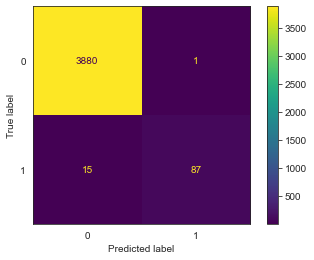

In [58]:
cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=y_test, 
        y_pred=opt_pipe_pred_test
    )
)
cm.plot()

In [59]:
rbso.config

[(1,
  ['RGDT_Rule256',
   'RGDT_Rule35',
   'RGDT_Rule313',
   'RGDT_Rule24',
   'RGDT_Rule153',
   'RGDT_Rule_20220803_23',
   'RGDT_Rule137'])]

---

## Convert generated rule conditions to system-ready <a name="ConvertGenToSys"></a>

In [63]:
rm = ReturnMappings()

imputed_values_mapping = rm.return_imputed_values_mapping(
    [num_cols, -1], 
    [cat_cols, 'missing'], 
    [bool_cols, 'missing']
)

ohe_categories_mapping = rm.return_ohe_categories_mapping(
    pre_ohe_cols=X.columns, 
    post_ohe_cols=X_train.columns, 
    pre_ohe_dtypes=X.dtypes
)

conv_gen_rules = ConvertProcessedConditionsToGeneral(
    imputed_values=imputed_values_mapping, 
    ohe_categories=ohe_categories_mapping
)

conv_gen_rule_strings = conv_gen_rules.convert(
    rule_strings=rg.rule_strings, 
    X=X_train
)

---

## Our final rule set and RBS Pipeline <a name="FinalRuleSet"></a>

In [68]:
rbs_rule_strings = {}
rbs_rule_strings.update(conv_gen_rule_strings)
rbs_rule_strings.update(ro.rule_strings)

rbs_rules = Rules(rule_strings=rbs_rule_strings)

In [70]:
rbs_rules.rule_strings

{'RGDT_Rule_20220803_23': "(X['account_number_num_fraud_transactions_per_account_number_7day']>=1)&(X['account_number_num_order_items_per_account_number_30day']>=9)&(X['account_number_sum_order_total_per_account_number_7day']>1020.59499)",
 'RGDT_Rule137': "((X['account_number_avg_order_total_per_account_number_7day']<=317.69)|(X['account_number_avg_order_total_per_account_number_7day'].isna()))&(X['account_number_num_fraud_transactions_per_account_number_1day']>=1)&(X['account_number_num_fraud_transactions_per_account_number_90day']>=1)&((X['account_number_sum_order_total_per_account_number_1day']<=782.375)|(X['account_number_sum_order_total_per_account_number_1day'].isna()))",
 'RGDT_Rule256': "(X['account_number_num_fraud_transactions_per_account_number_1day']>=1)&((X['account_number_sum_order_total_per_account_number_90day']<=950.89999)|(X['account_number_sum_order_total_per_account_number_90day'].isna()))&(X['is_billing_shipping_city_same']==False)",
 'RGDT_Rule35': "(X['account_n

In [71]:
rbso.config

[(1,
  ['RGDT_Rule256',
   'RGDT_Rule35',
   'RGDT_Rule313',
   'RGDT_Rule24',
   'RGDT_Rule153',
   'RGDT_Rule_20220803_23',
   'RGDT_Rule137'])]

---

### Inference

In [85]:
# input values for inference

avg_order_total_1day = 162.95
avg_order_total_7day= 162.95
avg_order_total_30day = 162.95
avg_order_total_90day = 162.95

num_distinct_transactions_1day = 1
num_distinct_transactions_7day = 1
num_distinct_transactions_30day = 1
num_distinct_transactions_90day = 1

num_fraud_transactions_1day = 0
num_fraud_transactions_7day = 0
num_fraud_transactions_30day =0
num_fraud_transactions_90day = 0
num_fraud_transactions_lifetime = 1

num_order_items_1day = 1
num_order_items_7day = 1
num_order_items_30day = 1
num_order_items_90day = 1
num_order_items_lifetime = 3

sum_order_total_1day = 162.95
sum_order_total_7day= 162.95
sum_order_total_30day = 162.95
sum_order_total_90day = 162.95

is_billing_shipping_city_same = 1
is_existing_user = 1
n_order_items = 2
order_total = 162.95

status_New = 1
status_Pending = 0
status_missing = 0

inputs =pd.DataFrame([[
    avg_order_total_1day,
    avg_order_total_7day,
    avg_order_total_30day,
    avg_order_total_90day,
    num_distinct_transactions_1day,
    num_distinct_transactions_7day,
    num_distinct_transactions_30day,
    num_distinct_transactions_90day,
    num_fraud_transactions_1day,
    num_fraud_transactions_7day,
    num_fraud_transactions_30day,
    num_fraud_transactions_90day,
    num_fraud_transactions_lifetime,
    num_order_items_1day,
    num_order_items_7day,
    num_order_items_30day,
    num_order_items_90day,
    num_order_items_lifetime,
    sum_order_total_1day,
    sum_order_total_7day,
    sum_order_total_30day,
    sum_order_total_90day,
    is_billing_shipping_city_same,
    is_existing_user,
    n_order_items,
    order_total,
    status_New,
    status_Pending,
    status_missing
]], columns = X_train.columns)


In [86]:
inputs.shape

(1, 29)

In [90]:
inference_generated_rules = rg.transform(X=inputs)
inference_optimized_rules = ro.transform(X=inputs)

inference_rules = pd.concat([inference_generated_rules, inference_optimized_rules], axis=1)

rbso.predict(inference_rules)[0]

0

### Saving the Models

In [98]:
def get_rg():
    return rg

pickle_out = open("models/rg.pkl","wb")
pickle.dump(rg, pickle_out)
pickle_out.close()

AttributeError: Can't pickle local object '_ConvertRuleDictsToRuleStrings._convert_to_lambda.<locals>._make_lambda.<locals>.<lambda>'

In [96]:
def get_ro():
    return ro

pickle_out = open("models/ro.pkl","wb")
pickle.dump(get_ro, pickle_out)
pickle_out.close()

In [97]:
def get_rbso():
    return rbso

pickle_out = open("models/rbso.pkl","wb")
pickle.dump(get_rbso, pickle_out)
pickle_out.close()